# Electrical Consumption Timeseries Forcasting

### Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Importing and Preprocessing Data

In [3]:
df = pd.read_csv("Data/PJME_hourly.csv")
df["Datetime"] = pd.DatetimeIndex(df["Datetime"])
df.set_index(df["Datetime"],inplace=True)
df.drop(columns = ["Datetime"],inplace=True)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.isnull().sum()

PJME_MW    0
dtype: int64

In [5]:
def Create_Features(data):
    data["hour"] = data.index.hour
    data["quarter"] = data.index.quarter
    data["year"] = data.index.year
    data["month"] = data.index.month
    data["day"] = data.index.day
    return data

In [6]:
df = Create_Features(df)
df.head()

,PJME_MW,hour,quarter,year,month,day
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,4,2002,12,31
2002-12-31 02:00:00,25147.0,2,4,2002,12,31
2002-12-31 03:00:00,24574.0,3,4,2002,12,31
2002-12-31 04:00:00,24393.0,4,4,2002,12,31
2002-12-31 05:00:00,24860.0,5,4,2002,12,31


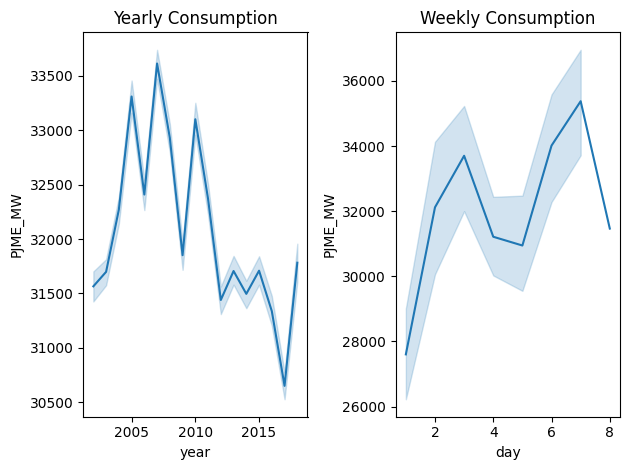

In [7]:
plt.subplot(1, 2, 1)

sns.lineplot(x = df["year"],y = df["PJME_MW"])
plt.title("Yearly Consumption")

plt.subplot(1, 2, 2)
wa = df.loc[(df.index >= "2003-01-01 00:00:00") & (df.index<= "2003-01-08 00:00:00")]


sns.lineplot(x = wa["day"],y = wa["PJME_MW"])
plt.title("Weekly Consumption")

plt.tight_layout()
plt.show()


In [8]:
train = df.loc[(df.index < "2015-01-01 00:00:00")]
test = df.loc[(df.index >= "2015-01-01 00:00:00")]

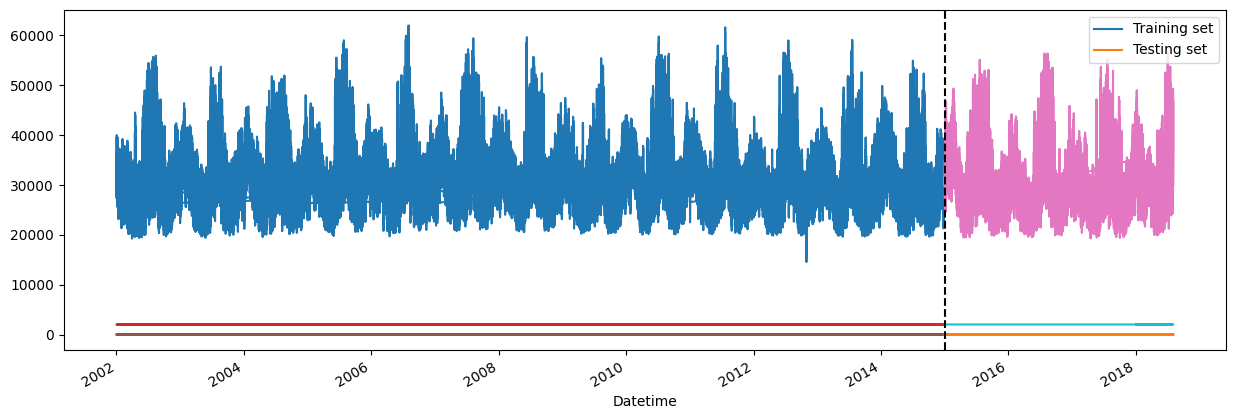

In [9]:
fig,ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax,label = "Training set")
test.plot(ax=ax,label = "Testing set")
ax.axvline("2015-01-01 00:00:00",color = "black",ls = "--")
ax.legend(["Training set","Testing set"])
plt.show()

### Generating Lag features

In [15]:
def Create_lag_Features(data):
    data["lag_1"] = data["PJME_MW"].shift(1*24)
    data["lag_7"] = data["PJME_MW"].shift(7*24*1)
    return data

df = Create_lag_Features(data = df)
df.dropna(inplace=True)
df.sort_index()
df.head()

,PJME_MW,hour,quarter,year,month,day,lag_1,lag_7
Datetime,,,,,,,,
2002-12-17 01:00:00,29971.0,1,4,2002,12,17,31149.0,27213.0
2002-12-17 02:00:00,29046.0,2,4,2002,12,17,30119.0,25643.0
2002-12-17 03:00:00,28653.0,3,4,2002,12,17,29870.0,24907.0
2002-12-17 04:00:00,28774.0,4,4,2002,12,17,30024.0,24721.0
2002-12-17 05:00:00,29453.0,5,4,2002,12,17,30733.0,25144.0
